# ASGCNN
The **adsorbate-site graph convolutional neural network** (**ASGCNN**) has the following architecture. It uses **unrelaxed adsorption  slab** structure as input. A **slab graph** and an **adsorbate-site graph** are then created. Features in these two graphs are convolved and aggregated to predict the **adsorption (free) energy** as well as **categories of adsorbate and adsorption site class**.

In [1]:
from ASGCNN.Model import ASGCNN, SGCNN, CGCNN
from ASGCNN.Trainer import Trainer
from ASGCNN.Encoder import Graph_data_loader, Encoder_structure, Encoder_element, Encoder_edge

import zipfile
import matplotlib.pyplot as plt

We use tqdm.notebook to show progress bar, if you are not using jupyter notebook or there is problems when using tqdm.notebook, go into Trainer and Encoder scripts, annotation "**from tqdm.notebook import tqdm as tqdm**" and use "**from tqdm import tqdm**".

# 1. use pretrained model
The pre-trained can load directly by the **load_pretrained** on **Trainer**. However, to define a **Trainer**, we must first create **Graph_data_loader**s.  

## 1.1 load dataset

Three parameters are needed for the creation of **Graph_data_loader**:
- a **csv file** that records the target values
- a **xx.bin** file that stores graph data (saved by dgl package)
- a **list of strings** of column names for the target values in the sequence of adsorbate category, site category and adsorption energy

Here, we load the dataset used in literature with 6,000 Heusler alloy adsorption energy data points, which were split into training, validation, and test sets in a ratio of 5000: 500: 500.   

Due to the file size limit, we need to extract part of the bin file first

In [3]:
with zipfile.ZipFile(r'data/Graph_adsb_train.zip', 'r') as zip_ref:
    zip_ref.extract('Graph_adsb_train.bin', 'data')
    
with zipfile.ZipFile(r'data/Graph_slab_train.zip', 'r') as zip_ref:
    zip_ref.extract('Graph_slab_train.bin', 'data')

Now, we can create **Graph_data_loader** and load data to it. Note that **batch size** is also specified when the **Graph_data_loader** is created.  

In [3]:
# list of target column names
target = ['Cadsb', 'Csite', 'Gads']

# load training set
train_excel =  'data/Train_data_5000.csv'
Encoders_train = ['data/Graph_adsb_train.bin', 'data/Graph_slab_train.bin']
Loader_train = Graph_data_loader(256) # 256 is the specified batch size for Loader_train here
Loader_train.load_data(train_excel, Encoders_train, target=target)

# load validation set
valid_excel = 'data/Valid_data_500.csv'
Encoders_valid = ['data/Graph_adsb_valid.bin', 'data/Graph_slab_valid.bin']
Loader_valid = Graph_data_loader(500)
Loader_valid.load_data(valid_excel, Encoders_valid, target=target)

# load test set
test_excel = 'data/Test_data_500.csv'
Encoders_test = ['data/Graph_adsb_test.bin', 'data/Graph_slab_test.bin']
Loader_test = Graph_data_loader(500)
Loader_test.load_data(test_excel, Encoders_test, target=target)

If you did not set **batch size** when create **Graph_data_loader**, or you want to change it, you can do this by:

In [4]:
Loader_train.batch_size = 512

Graphs are stored in the **.graphs** attribute of the **Graph_data_loader**. The **.graphs** attribute is a list with a shape of (*number of graph types*, *number of graphs*). For example, the **Loader_train** has two types of graphs (adsorbate-site graph and slab graph), so its shape will be (2, 5000). To access the first slab graph, you should:

In [5]:
g = Loader_train.graphs[1][0]
g

Graph(num_nodes=18, num_edges=168,
      ndata_schemes={'symbol': Scheme(shape=(), dtype=torch.int32), 'h_v': Scheme(shape=(101,), dtype=torch.float32)}
      edata_schemes={'radius': Scheme(shape=(), dtype=torch.float32), 'h_e': Scheme(shape=(8,), dtype=torch.float32)})

In [6]:
g.ndata['symbol']

tensor([49, 49, 49, 49, 29, 29, 29, 29,  1, 78, 78, 78, 78, 78, 78, 78, 78,  7],
       dtype=torch.int32)

## 1.2 load pre-trained models

Then, define the **ASGCNN** model with pre-trained parameters. Pass the model and data loaders together into a **Trainer** and use **.load_pretrained** to load pretrained models.   

Note that the task of regression and classification together (**multy**) is currently only applicable to our dataset. To apply it to your task, first go to the **Model.py** script and change the output dimensions of the categorical task.

In [7]:
# define a model with pre-adjusted hyperparameters 
Model = ASGCNN(101,6,110,101,8,150,3,[80,120,10],'silu','multy')

# create Trainer
t=Trainer(Model, Loader_train, Loader_valid, Loader_test, metric='hyb', metric_para=1-0.662)

# load pre-trained models
t.load_pretrained(location='cpu')

Now, we can get the same parity plot as in the paper.

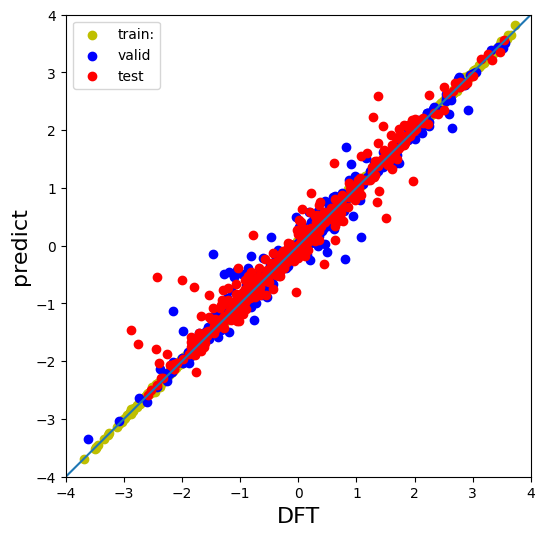

In [8]:
t.show_result()
# only when training, validation and test sets are all exist, can this functioin work

Different metrics can be checked by:

In [9]:
t.calculate_static()
# only when training, validation and test sets are all exist, can this functioin work

{'train': {'f1_1': 1.0,
  'f1_2': 1.0,
  'ac_1': 1.0,
  'ac_2': 1.0,
  'pc_1': 1.0,
  'pc_2': 1.0,
  'rc_1': 1.0,
  'rc_2': 1.0,
  'r2': 0.9997970084802672,
  'mae': 0.012860742,
  'mse': 0.00029508275,
  'rmse': 0.017177973},
 'valid': {'f1_1': 1.0,
  'f1_2': 1.0,
  'ac_1': 1.0,
  'ac_2': 1.0,
  'pc_1': 1.0,
  'pc_2': 1.0,
  'rc_1': 1.0,
  'rc_2': 1.0,
  'r2': 0.9770201972511355,
  'mae': 0.10485716,
  'mse': 0.034271825,
  'rmse': 0.18512651},
 'test': {'f1_1': 1.0,
  'f1_2': 1.0,
  'ac_1': 1.0,
  'ac_2': 1.0,
  'pc_1': 1.0,
  'pc_2': 1.0,
  'rc_1': 1.0,
  'rc_2': 1.0,
  'r2': 0.9608975034522517,
  'mae': 0.1315413,
  'mse': 0.058505304,
  'rmse': 0.2418787}}

## 1.3 make prediction
Finally, we show how to make a prediction on a dataset.

In [10]:
predict, uq = t.predict(Loader_test, to_class=True, return_uq=True)

In [11]:
Loader_test.target[:3]

tensor([[ 0.0000,  0.0000, -0.5184],
        [ 3.0000,  0.0000, -1.3138],
        [ 2.0000,  3.0000, -2.3946]])

In [12]:
predict[:3]

array([[ 0.        ,  0.        , -0.52548856],
       [ 3.        ,  0.        , -1.3168112 ],
       [ 2.        ,  3.        , -2.03720617]])

In [13]:
uq[:3]

array([0.0228996 , 0.03610364, 0.03876777], dtype=float32)

# 2. train from scratch
Here, we show how to train a network from scratch.  

Before using these codes for training, you should first prepare vasp structures and csv files that store input structure file names and target values. A Small dataset with 9 structres (6: 3 for training and validation set) is placed at **data/eaxmple** for the demonstration.

## 2.1 create dataset

First, define **Encoder_structure**s for structure to graph transformation. Here we create two encoders for transforming structures into adsorbate-site graph and slab graph respectively.  

The cutoff radius for neighbor atom finding is set to 3.36 by default, which ensures atoms on our **unrelaxed** and **lattice-fixed** slab can only bond to their first and second near neighbor atoms, and adsorbates can only bond to adsorption sites. You should determine this value based on the system you are studying.

The creation of **adsorbate-site graph**s is done by deleting substrate atoms that do not bond to adsorbate atoms. This is achieved by using the **element_restrict** parameter; by setting this to the elements of adsorbates, only adsorbate and site atoms will be used to create the graph.  

For further clarification about **Encoder_structure**, refer to:

In [ ]:
help(Encoder_structure)

In [14]:
Es_adsb = Encoder_structure(element_restrict={'N','H'})
Es_slab = Encoder_structure()

Then, we combine the **Encoder_structure** with the **Graph_data_loader** to load the dataset. When a **Encoder_structure** is passed to **Graph_data_loader**, it will read vasp structures and transform to dgl graphs automatically.  

For further clarification about **load_data**, refer to:

In [ ]:
help(Graph_data_loader.load_data)

In [15]:
file_paths = ['data/example/structure', 'data/example/structure']
file_columns = ['adsb', 'slab']
target = ['Gads']

Encoders = [Es_adsb, Es_slab]

# load training set
train_excel =  'data/example/Train_6.csv'
Loader_train = Graph_data_loader(3)
Loader_train.load_data(train_excel, Encoders, file_paths, file_columns, target=target)

# load validation set
valid_excel = 'data/example/Valid_3.csv'
Loader_valid = Graph_data_loader(3)
Loader_valid.load_data(valid_excel, Encoders, file_paths, file_columns, target=target)

Load graph:   0%|          | 0/12 [00:00<?, ?g/s]

Load graph:   0%|          | 0/6 [00:00<?, ?g/s]

After that, we need to define the feature encoder for the nodes (**Encoder_element**) and edges (**Encoder_edge**) and create corresponding features on the graph using (**.apply_feature** on data loader).  

For further clarification about **Encoder_element** and **Encoder_edge**, refer to:

In [ ]:
help(Encoder_element)

In [ ]:
help(Encoder_edge)

In [16]:
# feature encoder for adsorbate-site graph
Ef_node_adsb = Encoder_element(features=['group', 'period', 'electronegativity', 'radius', 'density', 'Zeff'])
Ef_edge_adsb = Encoder_edge(features=['category'])
# feature encoder for slab graph
Ef_node_slab = Encoder_element(features=['group', 'period', 'electronegativity', 'radius', 'affinity', 'weight'])
Ef_edge_slab = Encoder_edge(features=['category','distance'])

Then, deliver feature encoders to **Graph_data_loader**s.

In [17]:
Loader_train.apply_feature([Ef_node_slab, Ef_node_adsb],[Ef_edge_slab, Ef_edge_adsb])
Loader_valid.apply_feature([Ef_node_slab, Ef_node_adsb],[Ef_edge_slab, Ef_edge_adsb])

Apply feature:   0%|          | 0/12 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/6 [00:00<?, ?g/s]

Once the feature is apply, you can save graph data to xx.bin files, like:

In [18]:
Loader_train.save_data(r'data/example', ['adsb_train.bin', 'slab_train.bin'])
Loader_valid.save_data(r'data/example', ['adsb_valid.bin', 'slab_valid.bin'])

Use the **feature_lentgh_total** attribute on **Encoder_element** and **Encoder_edge** to view the length of features, these values are required parameters to initialize the model.

In [19]:
Ef_node_slab.feature_lentgh_total

60

In [20]:
Ef_edge_slab.feature_length_total

9

In [21]:
Ef_edge_adsb.feature_length_total

3

## 2.2 train a ASGCNN
Let us define a new ASGCNN model  

In [22]:
Model = ASGCNN(node_feat_length_adsb=60,# adsorbate-site graph feature length
               edge_feat_length_adsb=9,
               embedding_length_adsb=60,
               node_feat_length_slab=60,# slab graph feature length
               edge_feat_length_slab=3,
               embedding_length_slab=40,
               conv_number=3,  # convolution layer number
               fc_lens=[50, 20, 10], # fully connected layer (hidden layer) dimensions
               mlp_acti='silu', # activation function
               task_typ='regre',
               p_droput=0) # dropout rate

Finally, deliver the **Model** and **Graph_data_loader**s to a **Trainer**, and specified the **learning rate** and **metric**. **optimizer** and **scheduler** can also be specified when define a **Trainer**.

For further clarification about **Trainer**, refer to:

In [ ]:
help(Trainer)

In [23]:
t = Trainer(Model, Loader_train, Loader_valid, init_lr=0.01 , metric='mae')

Try train 10 epoch 

In [24]:
t.train(10)

Train epoch:   0%|          | 0/10 [00:00<?, ?e/s]

Note that, at present, one can only use **show_result** and **calculate_static** to check training results, when all training, validation and test sets exist. Hence we do not show the training result for examples.  

Trained model can be saved by:

In [25]:
t.save(r'data/example/model')

## 2.3 train other model
We also implemented frameworks of CGCNN and SGCNN, you can train these models to. Training process is the same as the former, you just need to change the model class.  

Let us try to train a CGCNN model using the slab graph only.

In [26]:
Model = CGCNN(node_feat_length=60,
              edge_feat_length=3,
              embed_feat_length=60,
              conv_number=3, 
              fc_lens=[40,20],
              mlp_acti='silu',
              task_typ='regre',
              p_droput=0)

Reload the slab graph data only, from the .bin file we just saved.

In [27]:
Loader_train = Graph_data_loader(6)
Loader_train.load_data(train_excel, [r'data/example/slab_train.bin'], target=target)

Loader_valid = Graph_data_loader(6)
Loader_valid.load_data(valid_excel, [r'data/example/slab_valid.bin'], target=target)

Now, train the CGCNN model

In [28]:
t = Trainer(Model, Loader_train, Loader_valid, init_lr=0.01 , metric='mae')

In [29]:
t.train(10)

Train epoch:   0%|          | 0/10 [00:00<?, ?e/s]

## 2.4 snapshot - ensemble
To use the [**snapshot ensemble**](https://arxiv.org/abs/1704.00109) (see also [Chinese interpretation](https://zhuanlan.zhihu.com/p/461565837)), using **.init_snapshot_ensembling**, this will change the **scheduler** on **Trainer**, and stored ensemble models during training process.

In [30]:
t = Trainer(Model, Loader_train, Loader_valid, init_lr=0.01 , metric='mae')

Define the number of models in the ensemble and after how many epochs a snapshot model is stored. Here, we use a **5-model** ensemble, with each model trained for **40 epochs**, resulting in a total training epoch count of **200**. You should increase the training epochs in a real session

In [31]:
t.init_snapshot_ensembling(cycle_time=5, epoch_each=40)

In [32]:
t.train(200)

Train epoch:   0%|          | 0/200 [00:00<?, ?e/s]

Now, let's check out the learning rate changing trend during the training process. You will find that the learning rate goes down to near zero every 40 epochs, and then returns to the initial learning rate. This process is repeated 5 times, and every time the learning rate approaches zero, a snapshot model is stored.

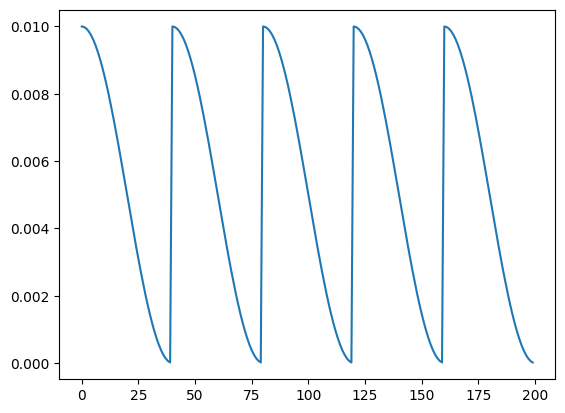

In [33]:
plt.plot(t.lrs)

Now the prediction is the average prediction values of 5 models, and the standard deviation of these values can be used to measure uncertainty

In [34]:
yp, uq = t.predict(Loader_valid, return_uq=True)

In [35]:
uq

array([[0.14517033],
       [0.15950643],
       [0.14959654]], dtype=float32)

## 2.5 effective label density
We also implemented the [**effective label density**](https://arxiv.org/abs/2102.09554) (see also [Chinese interpretation](https://zhuanlan.zhihu.com/p/369627086)) for regression task only. This will calculate a weight according to the target value distribution. The target values are divided into **different bins**, and the **probability distribution** is approximated by a **kernel function** Data points with low probability of target quantity distribution will have more weight. This make they have a greater impact on turing network parameters during training process.  

To use this method, run **.get_effective_label_density** at **Graph_data_loader** once you have loaded you training data.  

Since there are few data in the displayed cases, only two bins are given. When the data is enough, the effect will be more obvious.

In [36]:
Loader_train.get_effective_label_density(bin_number=2)

Weights of different bins can be check by

In [37]:
Loader_train.weights

tensor([[0.9952],
        [1.0048]])

In [38]:
Loader_train.target

tensor([[ 0.3027],
        [-1.2357],
        [-0.3916],
        [-1.3135],
        [ 1.8882],
        [-1.1804]])

According to the target values, the bin-seperate value should be 1.88 - -1.31 + -1.31 ~= 0.3,  min + (max-min) / bin_num   
You can see that only 0.3027 and 1.8882 fall into the second bin, so they have a higher weight. The weights are so close because the default parameters for the kernel function are not suitable for this small data situation.  

Use this data loader to train, the **effective label density** will be used to adjust the training result. This can only be used for a regression task. Now, let us define a new **Trainer** and choose the **wmae** metric.

In [39]:
t = Trainer(Model, Loader_train, Loader_valid, init_lr=0.01, metric='wmae')

In [40]:
t.train(10)

Train epoch:   0%|          | 0/10 [00:00<?, ?e/s]

Let's look at a more intuitive one, use the previous 500 verification sets as the training set, see how **effective label density** works now. For different data sets you need to **adjust the hyperparameters** to get better results.

In [10]:
target=['Gads']
excel = 'data/Valid_data_500.csv'
Encoders = ['data/Graph_slab_valid.bin']
Loader = Graph_data_loader(500)
Loader.load_data(excel, Encoders, target=target)

In [21]:
Loader.get_effective_label_density(bin_number=30)

We split different target values into 30 bins, you can see that most of the target quantities are distributed in the middle.

Text(0, 0.5, 'Effective label density')

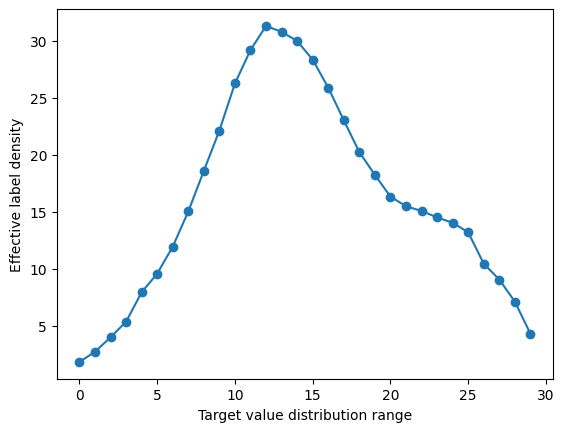

In [38]:
plt.plot(range(len(Loader.effective_label_density)), Loader.effective_label_density, marker='o')
plt.xlabel('Target value distribution range'); plt.ylabel('Effective label density')

In this case, the data points with target value distributed in the center will get a smaller weight, and data points on the two sides will have a larger weight

Text(0, 0.5, 'Weight')

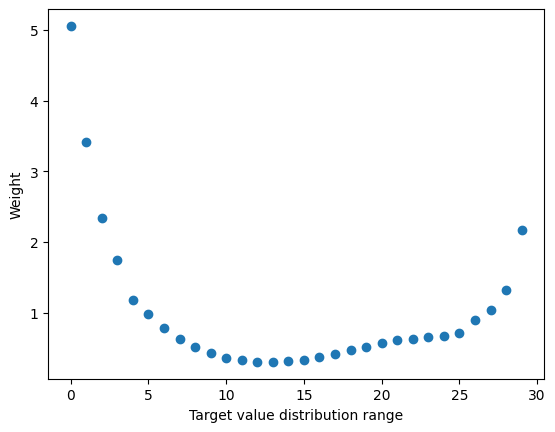

In [39]:
plt.scatter(range(len(Loader.effective_label_density)), Loader.weights)
plt.xlabel('Target value distribution range'); plt.ylabel('Weight')

## 2.6 hyperparameter tuning
We using [**hyperopt**](http://hyperopt.github.io/hyperopt/) (see also [Chinese interpretation](https://cloud.tencent.com/developer/article/2009339)) to tune hyperparameters, an example is as follow. It can run directly, need some adjustment by youself.

In [ ]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss
from ASGCNN.Trainer import setup_seed, HybLoss

In [ ]:
# define search space
search_params={
   'conv_num': hp.choice('conv_num',[1,2,3,4,5]),
   'adsb_eml': hp.quniform('adsb_eml',60,201,10),
   'slab_eml': hp.quniform('slab_eml',60,201,10),
   'fcly_1em': hp.quniform('fcly_1em',60,201,10),
   'fcly_2em': hp.quniform('fcly_2em',10,161,10),
   'fcly_3em': hp.quniform('fcly_3em',10,101,10),
   'loss_w': hp.uniform('loss_w',0.001,1),
}

# define objective function
def run_opt_in_para_set(params):
    setup_seed(123456) # fix seed for repeatable and comparable results
    Loader_train, Loader_valid, Loader_test = load_data() # load_data() is a function taht encapsulates the process of loading the datasets
   
    Loader_train.batch_size=256 # set batch_szie, this can also be a hyperparameter
    # define the model
    fcl = [int(params['fcly_1em']),int(params['fcly_2em']),int(params['fcly_3em'])]
    SA = AGCNN(101,6,int(params['adsb_eml']),101,8,int(params['slab_eml']),params['conv_num'],fcl,'Ce')
    # deinfe the trainer
    t=Trainer(SA, Loader_train, Loader_valid, Loader_test, init_lr=0.01, # lr can also be a hyperparameter
              metric='hyb', metric_para=params['loss_w'], 'AdamW', 'cos', 200)
    t.train_(100)
   
    return t.calculate_static()['valid']['mae']

# define search process
def param_hyperopt(max_evals=66):
    trials=Trials()
   
    early_stop=no_progress_loss(100)
   
    params_best= fmin(run_opt_in_para_set,
                   space=search_params,
                   algo=tpe.suggest,
                   max_evals=max_evals,
                   verbose=True,
                   trials=trials,
                   early_stop_fn=early_stop)
    return params_best, trials

In [ ]:
# run hyperparameter search with 360 evals
param_hyperopt(360)